# Sklonowanie i wejście do repozytorium



In [2]:
!git clone https://github.com/shizzeer/credo-classifier.git

Cloning into 'credo-classifier'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 82 (delta 37), reused 60 (delta 22), pack-reused 0
Receiving objects: 100% (82/82), 8.89 MiB | 6.76 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [3]:
%cd credo-classifier

/content/credo-classifier


# Rozpakowanie danych treningowych

In [ ]:
!unzip images.zip

# Usunięcie klasy artefacts ze zbioru danych

In [5]:
!rm -r images/artefacts

# Zaimportowanie bibliotek

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import *
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, \
                                    Input
from tensorflow.keras.models import Sequential, save_model
from sklearn.model_selection import KFold
import pickle

# Module autoreloading
%load_ext autoreload
%autoreload 2

# Załadowanie zestawu danych treningowych i walidacyjnych


In [7]:
BATCH_SIZE = 80
VALIDATION_SPLIT = 0.3
(train_ds, validation_ds) = load_dataset('./images/', batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Found 1232 files belonging to 3 classes.
Using 863 files for training.
Found 1232 files belonging to 3 classes.
Using 369 files for validation.


# Zmiana kolejności obrazów wewnątrz zbiorów danych - shuffling

W tym momencie zestaw treningowy nie zawiera żadnych obrazów z klasy worms, natomiast cały zestaw walidacyjny składa się z obrazów z klasy worms. Należy więc wymieszać dataset złożony z tych dwóch zestawów danych i rozdzielić obrazy ponownie. Dzięki temu uzyskane zestawy danych będą odpowiednio różnorodne wewnątrz

In [8]:
train_ds_batches = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_batches = tf.data.experimental.cardinality(validation_ds).numpy()
train_ds_size = train_ds_batches * BATCH_SIZE
validation_ds_size = validation_ds_batches * BATCH_SIZE

concatenated_ds = train_ds.concatenate(validation_ds)
concatenated_ds = concatenated_ds.shuffle(train_ds_size + validation_ds_size, seed=42, reshuffle_each_iteration=False)

Podział na zestaw treningowy i walidacyjny już po dokonanym przetasowaniu

In [9]:
train_ds = concatenated_ds.take(train_ds_batches)
validation_ds = concatenated_ds.skip(train_ds_batches).take(validation_ds_batches)

# Uzyskanie zbioru testowego

Zbiór walidacyjny posłuży dla modelu do optymalizacji hiperparametrów. Potrzebny jest dodatkowy zestaw testowy za pomocą, którego sprawdzimy rzeczywistą umiejętność modelu do generalizacji. Zbiór testowy stanowi 10% zestawu walidacyjnego.

Przed uzyskaniem zestawu testowego, zestaw walidacyjny zostanie przetasowany. Dzięki temu w zestawie testowym powinniśmy otrzymać obrazy o różnych klasach

In [10]:
validation_ds = validation_ds.shuffle(validation_ds_size, seed=42, reshuffle_each_iteration=False)
# 10% test set
test_ds = validation_ds.take(validation_ds_batches // 3)
# 20% validation set
validation_ds = validation_ds.skip(validation_ds_batches // 3)

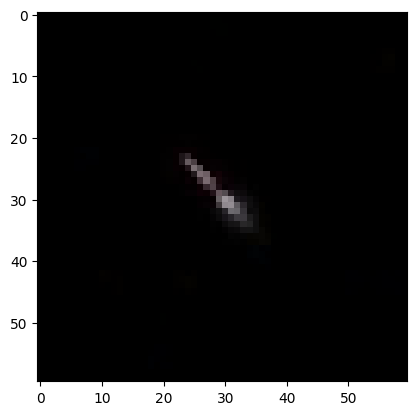

In [11]:
img_batch = train_ds.take(1)
batch_iterator = iter(img_batch)
image, label = next(batch_iterator)

plt.imshow(image[15].numpy().astype("uint8"))

In [ ]:
np.count_nonzero(image[15].numpy().astype("uint8"))

10800

# Wykres przedstawiający rozkład ilości obrazów na klasę

Pod uwagę wzięty został zbiór danych treningowych

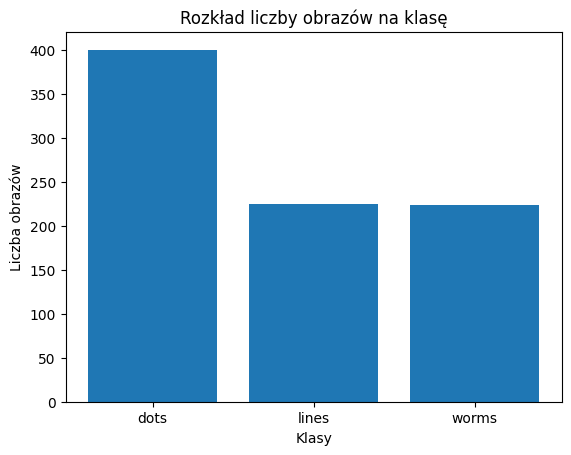

In [12]:
# Nazwy klas
class_names = ['dots', 'lines', 'worms']

# Dla każdej nazwy klasy musimy mieć ilość sklasyfikowanych obrazow
class_members_count = {class_name: 0 for class_name in class_names}

for _, labels in train_ds:
  for label in labels.numpy():
    class_name = class_names[label]
    class_members_count[class_name] += 1

plt.bar(class_members_count.keys(), class_members_count.values())
plt.xlabel('Klasy')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład liczby obrazów na klasę')
plt.show()

# Preprocessing obrazów

Preprocessing jest na ten moment dokonywany w bardzo prosty aczkolwiek efektywny sposób. Każdy piksel obrazu jest podzielony przez 255 wskutek czego trafia on do zbioru wartości [0, 1].

Dzięki takiej operacji żadna cecha obrazu nie staje się ważniejsza podczas procesu trenowania modelu. W efekcie otrzymamy model, który będzie brał pod uwagę każdy piksel obrazu podczas jego przetwarzania.


In [ ]:
# preprocessed_images = []

# for images, labels in train_ds:
#   for image in images:
#     processed_image = preprocess_image(image)
#     preprocessed_images.append(processed_image)
#preprocessed_train_ds = train_ds.map(preprocess_image)
#preprocessed_validation_ds = validation_ds.map(preprocess_image)

# Model sieci konwolucyjnej (CNN)

Sieć konwolucyjna będzie zdefiniowana w stylu tzw. **feature pyramid**. Oznacza to, że z każdą kolejną warstwą konwolucyjną przestrzeń obrazu będzie się zmniejszać natomiast zwiększać się będzie ilość kanałów.

W ten sposób wczesne warstwy będą wykrywać proste cechy obrazu takie jak na przykład krawędzie natomiast dalsze warstwy będą wykrywać coraz to bardziej skomplikowane i abstrakcyjne cechy.

Z każdą kolejną warstwą idąc głębiej w sieć "oddalamy się" od szczegółów poprzez zmniejszanie przestrzeni obrazu, lecz zwiększamy ilość wykrywanych cech co powinno dać pożądany, opisany powyżej efekt.

Model będzie składał się z warstw:


*   Conv2D
*   MaxPooling2D
*   FC (Fully Connected Network)

## Preprocessing

Przed wprowadzeniem danych do sieci neuronowej w celu jej wytrenowania dane te są przetwarzane w taki sposób, aby ustabilizować proces treningu oraz zwiększyć możliwości generalizacji modelu.

Operacje, które przygotowują dane:

*    Rescaling - każdy piksel obrazu jest przeskalowany do zbioru [0, 1] co stabilizuje proces treningu modelu

*    Random horizontal and vertical flip - odbicie obrazu odpowiednio wzdłuż osi x oraz wzdłuż osi y. Odbicia są dokonywane losowo

*    Random rotation - losowe obrócenie obrazu w pewnym przedziale [-n% * 2pi, n% * 2pi] gdzie n to argument podany do warstwy

*    Random zoom - losowe powiększenie lub pomniejszenie się obrazu w przedziale [n%, n%] gdzie n to argument podany do warstwy







## Stałe

In [13]:
DENSE_UNITS = 20
NUM_EPOCHS = 1500
NUM_CLASSES = 3

In [14]:
class CNNClasifier(tf.keras.Model):
  def __init__(self, num_filters=30, dense_units=DENSE_UNITS, num_classes=NUM_CLASSES):
    # Wywołanie konstruktora klasy nadrzędnej, czyli tf.keras.Model
    super().__init__()

    # Preprocessing
    self.preprocessing = Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3)
    ])

    # Definicja warstw konwolucyjnych
    self.conv1 = Conv2D(num_filters, # number of filters (30)
                        3, # kernel size
                        activation='relu',
                        kernel_initializer="he_normal")

    self.max_pool1 = MaxPooling2D(strides=2)

    self.conv2 = Conv2D(num_filters*2, # number of filters (60)
                        3, # kernel size
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout1 = Dropout(0.2)

    self.max_pool2 = MaxPooling2D(strides=2)

    self.conv3 = Conv2D(num_filters*3, # number of filters (90)
                        3, # kernel size
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout2 = Dropout(0.4)

    self.flatten = Flatten()

    self.dense1 = Dense(dense_units,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout3 = Dropout(0.3)

    self.dense2 = Dense(dense_units*0.5,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.output_layer = Dense(num_classes,
                              activation='linear')

    # self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                      patience=20,
    #                                                      restore_best_weights=True)

  # Forward pass
  def call(self, inputs, training=False):
    x = self.preprocessing(inputs)
    x = self.conv1(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    if training:
      x = self.dropout1(x)
    x = self.max_pool2(x)
    x = self.conv3(x)
    if training:
      x = self.dropout2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    if training:
      x = self.dropout3(x)
    x = self.dense2(x)
    return self.output_layer(x)

## Trening i kompilacja modelu

In [ ]:
cnn_model = CNNClasifier()

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Zapisanie historii uczenia się modelu w celu wizualizacji wykresu funkcji straty od liczby epok

history = cnn_model.fit(train_ds,
    batch_size=80,
    epochs=NUM_EPOCHS,
    validation_data=validation_ds)
    # callbacks=[cnn_model.early_stopping])

In [ ]:
tf.data.experimental.cardinality(validation_ds)
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=11>

## Zapisanie lub wczytanie historii wytrenowanego modelu

In [ ]:
with open('model_train_history', 'wb') as pickle_f:
  pickle.dump(history.history, pickle_f)

In [ ]:
with open('model_train_history', 'rb') as pickle_f:
  history = pickle.load(pickle_f)

## Załadowanie wytrenowanego modelu

Ta sekcja powinna być używana tylko i wyłącznie wtedy kiedy posiadamy zapisaną architekturą, wagi oraz stan optymalizatora wcześniej wytrenowanego modelu. Wówczas pomija się trening i używa dopasowanego modelu do dokonywania klasyfikacji obrazów

In [15]:
from tensorflow.keras.models import load_model
cnn_model = load_model('cnn_model')

## Ocena jakości klasyfikacji modelu

Ocena jakości modelu została dokonana za pomocą metody k-fold. Zbiór danych treningowych został podzielony na 5 równych części. Każda z tych części podczas jednej z pięciu iteracji pełniła rolę zbioru walidacyjnego. Model został wytrenowany dokładnie pięć razy za każdym razem z innym podziałem danych na treningowe i walidacyjne. Na koniec została policzona średnia z pięciu ocen jego jakości. Dzięki temu ocena jakości modelu nie jest zależna od pojedynczego podziału zbioru danych na zestaw treningowy i walidacyjny.

In [ ]:
# Konwertowanie datasetów do tablicy numpy
train_images = np.concatenate(list(train_ds.map(lambda img, label: img)))
train_labels = np.concatenate(list(train_ds.map(lambda x, y: y)))
validation_images = np.concatenate(list(validation_ds.map(lambda x, y: x)))
validation_labels = np.concatenate(list(validation_ds.map(lambda x, y: y)))

print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Validation images shape: ', validation_images.shape)
print('Validation labels shape: ', validation_labels.shape)

Train images shape:  (849, 60, 60, 3)
Train labels shape:  (849,)
Validation images shape:  (303, 60, 60, 3)
Validation labels shape:  (303,)


In [ ]:
# Połączenie ze sobą zestawu treningowego oraz walidacyjnego
inputs = np.concatenate((train_images, validation_images), axis=0)
targets = np.concatenate((train_labels, validation_labels), axis=0)

print('Inputs shape: ', inputs.shape)
print('Targets shape: ', targets.shape)

Inputs shape:  (1152, 60, 60, 3)
Targets shape:  (1152,)


### K-fold cross validation

Dla k = 5

In [ ]:
# Założenie bazowe dla modelu -> zbiór walidacyjny stanowi 20% zbioru treningowego
num_of_folds = 5
k_fold = KFold(n_splits=num_of_folds, shuffle=True)

accuracy_scores = []
losses = []

for fold, (train, val) in enumerate(k_fold.split(inputs, targets)):
  print(f"Fold {fold + 1}/{num_of_folds}")

  cnn_model = CNNClasifier()

  # Wyzerowanie wag modelu
  cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  print('Training shape: ', inputs[train].shape)
  print('Validation shape: ', inputs[val].shape)

  cnn_model.fit(inputs[train],
                targets[train],
                batch_size=80,
                epochs=NUM_EPOCHS,
                validation_data=(inputs[val], targets[val]))

  loss, accuracy_score = cnn_model.evaluate(inputs[val], targets[val])
  accuracy_scores.append(accuracy_score)
  losses.append(loss)

score = np.mean(accuracy_scores)
mean_loss = np.mean(losses)
print(f"Validation score: {score}")
print(f"Validation loss: {mean_loss}")

In [ ]:
test_ds_eval = cnn_model.evaluate(test_ds)
print("Test Set - Loss:", test_ds_eval[0], "Accuracy:", test_ds_eval[1])

1/1 [==============================] - 0s 173ms/step - loss: 5.5692e-04 - accuracy: 1.0000
Test Set - Loss: 0.0005569181521423161 Accuracy: 1.0


## Wykres funkcji straty od liczby epok

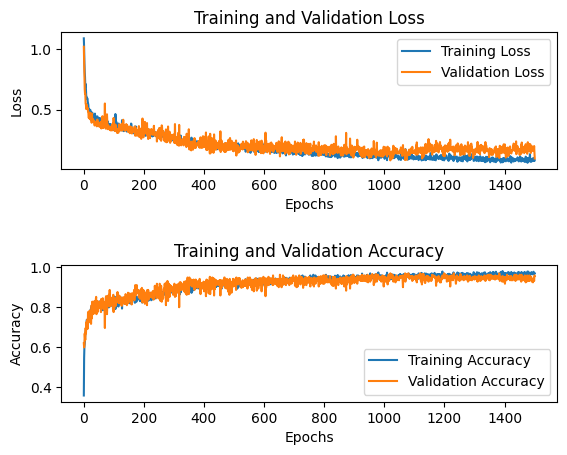

In [ ]:
train_loss = history['loss']
validation_loss = history['val_loss']
epochs = range(1, NUM_EPOCHS + 1)

fig, arr = plt.subplots(2, 1)
arr[0].plot(epochs, train_loss, label='Training Loss')
arr[0].plot(epochs, validation_loss, label='Validation Loss')
arr[0].set_title('Training and Validation Loss')
arr[0].set_xlabel('Epochs')
arr[0].set_ylabel('Loss')
arr[0].legend()

plt.subplots_adjust(hspace=0.7)

train_acc = history['accuracy']
validation_acc = history['val_accuracy']
arr[1].plot(epochs, train_acc, label='Training Accuracy')
arr[1].plot(epochs, validation_acc, label='Validation Accuracy')
arr[1].set_title('Training and Validation Accuracy')
arr[1].set_xlabel('Epochs')
arr[1].set_ylabel('Accuracy')
arr[1].legend()

In [ ]:
cnn_model.summary()

Model: "cnn_clasifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 60, 60, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           multiple                  840       
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  16260     
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_7 (MaxPoolin  multiple                  0         
 g2D)                                              

## Klasyfikacja za pomocą wytrenowanego modelu

Klasyfikacja na zestawie testowym

3/3 [==============================] - 0s 6ms/step


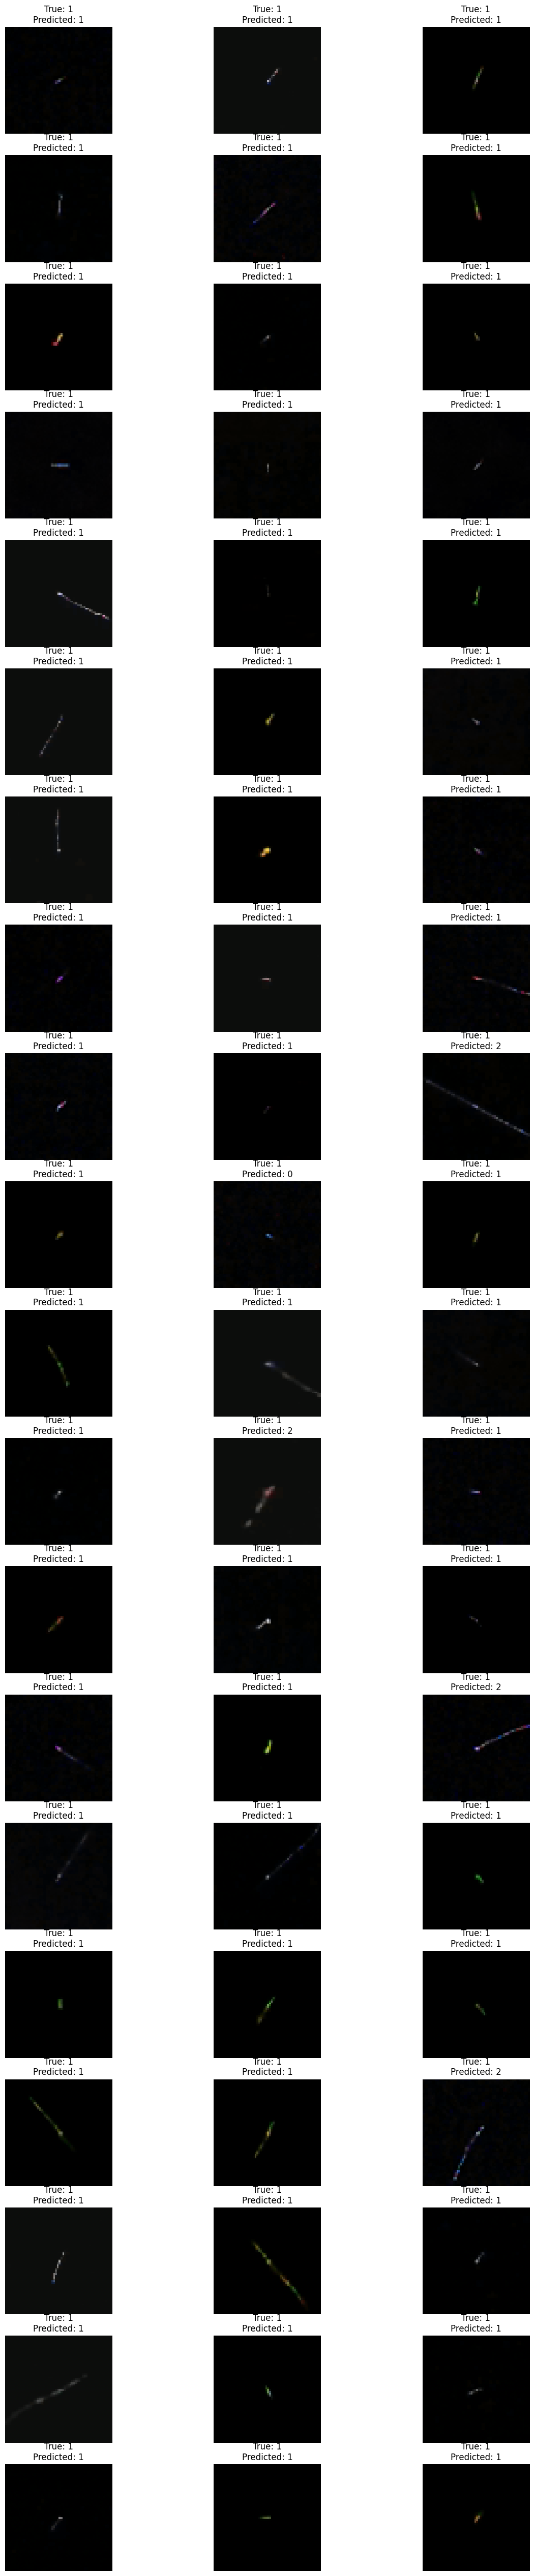

In [ ]:
#test_ds = test_ds.map(lambda x, y: (x / 255.0, y))
images, labels = next(iter(test_ds))
# Make predictions for the batch
predictions = cnn_model.predict(images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

rows = 20
cols = 3
fig = plt.figure(figsize=(15,65))
img_idx = 0

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(image[img_idx].numpy().astype("uint8"))
    plt.title(f"True: {labels[img_idx].numpy()}\nPredicted: {predicted_labels[img_idx]}")
    plt.axis('off')
    img_idx += 1
plt.show()

## Zapisanie modelu CONV w formacie SavedModel

Zapisanie modelu obejmuje:


*   Zapis architektury
*   Zapis wag
*   Zapis funkcji straty
*   Zapis stanu optimizera

Po ponownym załadowaniu modelu ze stworzonego katalogu będziemy mieć model gotowy do dokonywania przewidywań


In [ ]:
cnn_model.save('cnn_model')

# PCA

Metoda redukcji wymiarów Principal Component Analysis jest techniką, która znajduje wzorce wśród cech danych wejściowych na podstawie ich wzajemnej korelacji. Celem metody PCA jest zredukowanie wymiarów danych wejściowych w taki sposób, aby liczba wymiarów była mniejsza bądź równa liczbie wymiarów sprzed tranformacji przy zachowaniu jak największej ilości informacji.

Aby zachować jak największą ilość informacji po zredukowaniu liczby wymiarów PCA skupia się na wyznaczeniu kierunków wektorów, które **maksymalizują** wariancję pomiędzy cechami w wielo-wymiarowej przestrzeni. Następnie dane z wielo-wymiarowej przestrzeni są rzutowane na znalezione wektory skutecznie redukując wymiary przy zachowaniu przeważającej części informacji.

Prostopadłe do siebie wektory z nowej podprzestrzeni, których kierunki wyznaczają największą wariancję między cechami danych są nazywane **principal components** lub po polsku **składowe główne**. **Składowe główne są od siebie niezależne.**

Cechy są rzutowane na utworzone składowe główne. Pierwsza składowa główna odpowiada kierunkowi największej wariancji między cechami danej wejściowej wraz z kolejnymi składowymi głównymi ta wariancja między cechami maleje. W związku z tym pierwsza składowa główna zachowuje najwięcej informacji.

**Pojedyncza składowa główna odpowiada pojedynczemu wymiarowi w nowej przestrzeni.**

## Właściwości PCA

1. Liczba składowych głównych jest <= liczbie wymiarów zestawu danych
2. Składowe główne są do siebie prostopadłe => są niezależne względem siebie
3. Informacja zachowana na składowych głównych **zmniejsza się** wraz z kolejnymi składowymi głównymi

## Jak działa PCA?

PCA wykonuje następujące operacje, aby wyznaczyć składowe główne dla danego zestawu danych.

1. Normalizacja danych
2. Obliczenie macierzy kowariancji
3. Obliczenie wektorów własnych oraz wartości własnych macierzy kowariancji
4. Posortowanie wartości własnych malejąco
5. Wyznaczenie

Macierz kowariancji - wyraża podobieństwo między wszystkimi cechami z zestawu danych. **Dodatnia kowariancja** oznacza, że dwie cechy są do siebie proporcjonalne. **Ujemna kowariancja** - dwie cechy są do siebie odwrotnie proporcjonalne.

Wektory i wartości własne - służą do generowania nowego zestawu danych ze starego zestawu danych. Nowy zestaw danych będzie użyty do utworzenia składowych głównych.

## Model PCA -> MLP -> y

## Import dodatkowych bibliotek

In [19]:
from sklearn.decomposition import PCA

## Multi-Layer Perceptron z sieci konwolucyjnej

In [16]:
class MLP(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.flatten = Flatten()

    self.dense1 = Dense(DENSE_UNITS,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout1 = Dropout(0.3)

    self.dense2 = Dense(DENSE_UNITS*0.5,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.output_layer = Dense(NUM_CLASSES,
                              activation='linear')

  def call(self, inputs, training=False):
    x = self.flatten(inputs)
    x = self.dense1(x)
    if training:
      x = self.dropout1(x)
    x = self.dense2(x)
    return self.output_layer(x)

In [17]:
mlp = MLP()

In [18]:
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Konwersja Tensorflow dataset -> NumPy dataset

Konwersja ta jest potrzebna, aby zbiór treningowy mógł zostać przetworzony przez PCA z biblioteki scikit-learn.

In [83]:
# 1. Dane z tfds jako tablice
train_samples = []
train_labels = []

for images, labels in tf.data.Dataset.as_numpy_iterator(train_ds):
  train_samples.extend(images)
  train_labels.extend(labels)

# train_samples -- każdy element jest pojedynczym obrazem (60,60,3)
# train_labels -- każdy element jest intem

# 2. Wypłaszczamy obrazy
train_samples = np.array([image.flatten() for image in train_samples])
assert(train_samples.shape[1] == 60*60*3)
print(train_samples.shape)
print(train_samples[0].shape)

# W tym momencie mam już tablicę train_samples o wymiarach (n_samples, n_features)

(849, 10800)
(10800,)


## Normalizacja

In [87]:
# TO DO

## Redukcja wymiarów

In [86]:
N_COMPONENTS=150
pca = PCA(n_components=N_COMPONENTS)
pca.fit(train_samples)
print(pca.explained_variance_ratio_)

[4.6920225e-01 6.1139554e-02 2.7507773e-02 2.4553493e-02 2.0148059e-02
 1.7658357e-02 1.6479956e-02 1.4230227e-02 1.3255117e-02 1.2429146e-02
 1.1882509e-02 1.1326071e-02 1.0682145e-02 9.6456660e-03 9.3397871e-03
 8.4955981e-03 7.8147436e-03 7.3945657e-03 7.1513420e-03 6.9502108e-03
 6.6963155e-03 6.2746746e-03 6.1807954e-03 5.8230506e-03 5.5745151e-03
 5.1483302e-03 4.6757231e-03 4.3910518e-03 4.1107661e-03 4.0186197e-03
 3.9458405e-03 3.9373050e-03 3.5338188e-03 3.4373635e-03 3.2615585e-03
 3.1872420e-03 3.1243598e-03 3.0997337e-03 2.8960437e-03 2.8052516e-03
 2.6925979e-03 2.6047451e-03 2.5547247e-03 2.4119457e-03 2.3777967e-03
 2.3656790e-03 2.1819102e-03 2.1294935e-03 2.0801823e-03 2.0334963e-03
 1.9838237e-03 1.9675212e-03 1.9174995e-03 1.8606581e-03 1.7673256e-03
 1.7378795e-03 1.7209884e-03 1.6477210e-03 1.6370844e-03 1.5724591e-03
 1.5390009e-03 1.4887934e-03 1.4742558e-03 1.4274532e-03 1.4048346e-03
 1.3548825e-03 1.2963845e-03 1.2911379e-03 1.2731289e-03 1.2719369e-03
 1.217

# Czyszczenie środowiska i zapis na Github

In [ ]:
!cp ../drive/MyDrive/Colab\ Notebooks/credo_image_classifier.ipynb .

In [ ]:
!rm -r images

In [ ]:
#!git config --global user.email "eronics00@gmail.com"
#!git config --global user.name "Kamil Szpakowski"
!git status
!git add *
!git commit -m "Beginning of building PCA + MLP model"

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   credo_image_classifier.ipynb
	modified:   utils.py

no changes added to commit (use "git add" and/or "git commit -a")
The following paths are ignored by one of your .gitignore files:
__pycache__
hint: Use -f if you really want to add them.
hint: Turn this message off by running
hint: "git config advice.addIgnoredFile false"
[main ec3773d] Beginning of building PCA + MLP model
 2 files changed, 24 insertions(+), 1 deletion(-)
 rewrite credo_image_classifier.ipynb (93%)


In [ ]:
!git push https://<token>@github.com/shizzeer/credo-classifier.git

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 30.31 KiB | 2.75 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/shizzeer/credo-classifier.git
   1cb5c49..ec3773d  main -> main
